# Lesson 3: ResNet18 Transfer Learning for Flower Classification

## Overview
Learn transfer learning with ResNet18 on the Flowers102 dataset. This lesson demonstrates how pre-trained models can be adapted for new classification tasks with minimal training time.

### Learning Objectives
- Understand ResNet18 architecture and residual connections
- Implement transfer learning with pre-trained weights
- Use progressive training strategy (freeze → fine-tune)
- Evaluate model performance and analyze results

### Model Quick Facts
- **Architecture**: ResNet18 (18 layers, 11.7M parameters)
- **Pre-training**: ImageNet dataset (1.2M images, 1000 classes)
- **Key Innovation**: Residual connections for deep network training
- **Transfer Method**: Feature extraction + fine-tuning
- **Expected Performance**: ~85%+ accuracy on Flowers102


## Step 1: Environment Setup and Library Imports

### Key Libraries:
- **torch**: Core PyTorch library (tensors, automatic differentiation, neural networks)
- **torchvision**: Computer vision utilities (datasets, transforms, pre-trained models)
- **models**: Pre-trained model architectures (ResNet18, VGG, etc.)
- **optim**: Optimization algorithms (SGD, Adam, AdamW)
- **DataLoader**: Efficient batch processing and parallel data loading
- **tqdm**: Progress bars for training loops
- **matplotlib**: Data visualization and plotting
- **sklearn**: Machine learning utilities (metrics, confusion matrix)



In [1]:
# Core PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Computer vision utilities
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

# Remove sklearn import since we don't use it in training
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-quality plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.style.use('default')

print("✅ Libraries imported successfully!")
print(f"📦 PyTorch version: {torch.__version__}")
print(f"🖼️ Torchvision version: {torchvision.__version__}")
print(f"🔥 CUDA available: {torch.cuda.is_available()}")
print(f"🍎 MPS available: {torch.backends.mps.is_available()}")

✅ Libraries imported successfully!
📦 PyTorch version: 2.2.2
🖼️ Torchvision version: 0.17.2
🔥 CUDA available: False
🍎 MPS available: True


## Step 2: Device Detection and Configuration

### Device Selection Strategy
Transfer learning benefits significantly from GPU acceleration. Our device detection follows this priority:

1. **CUDA GPU** (NVIDIA): Optimal for deep learning training
   - Parallel processing with thousands of cores
   - Large memory capacity for batch processing
   - Highly optimized for matrix operations

2. **MPS (Apple Silicon)**: Apple's Metal Performance Shaders
   - Efficient on M1/M2 chips
   - Unified memory architecture
   - Good performance for development and medium-scale training

3. **CPU**: Universal fallback
   - Works on any system
   - Slower but sufficient for learning purposes

### Training Configuration
We use standardized parameters for consistent comparison across all lessons:
- **Batch Size**: 32 (balances memory usage and gradient quality)
- **Learning Rate**: 0.001 (standard for AdamW optimizer)
- **Epochs**: 50 total (20 frozen + 30 fine-tuning)
- **Optimizer**: AdamW with weight decay


In [2]:
# Device detection with fallback hierarchy
print("🔍 Detecting optimal compute device...")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"🚀 Using NVIDIA GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Using Apple Silicon GPU (MPS)")
    print("   Optimized for M1/M2 chips")
else:
    device = torch.device("cpu")
    print("💻 Using CPU (consider GPU for faster training)")

# Set training configuration
print("\n⚙️ Setting up training configuration...")
config = {
    'batch_size': 32,
    'learning_rate': 0.001,
    'epochs': 50,
    'freeze_epochs': 20,
    'finetune_epochs': 30,
    'num_workers': 2,
    'weight_decay': 0.01
}

print(f"   📦 Batch size: {config['batch_size']}")
print(f"   🎯 Learning rate: {config['learning_rate']}")
print(f"   🔄 Total epochs: {config['epochs']} (freeze: {config['freeze_epochs']}, fine-tune: {config['finetune_epochs']})")
print(f"   👥 Workers: {config['num_workers']}")
print(f"   ⚖️ Weight decay: {config['weight_decay']}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

print("\n✅ Configuration complete!")


🔍 Detecting optimal compute device...
🍎 Using Apple Silicon GPU (MPS)
   Optimized for M1/M2 chips

⚙️ Setting up training configuration...
   📦 Batch size: 32
   🎯 Learning rate: 0.001
   🔄 Total epochs: 50 (freeze: 20, fine-tune: 30)
   👥 Workers: 2
   ⚖️ Weight decay: 0.01

✅ Configuration complete!


## Step 3: Data Preprocessing and DataLoader Setup

### Data Augmentation Strategy

**Why Augmentation is Critical:**
- **Increases Effective Dataset Size**: Transforms create new variations of existing images
- **Improves Generalization**: Model learns to handle variations in real-world data
- **Reduces Overfitting**: Prevents memorization of specific image characteristics
- **Handles Data Scarcity**: Particularly important for smaller datasets like Flowers102

**Training vs. Validation Transforms:**
- **Training**: Aggressive augmentation for maximum variety and robustness
- **Validation/Test**: Minimal transforms for consistent, reproducible evaluation

### ImageNet Normalization
Pre-trained models require ImageNet statistics for optimal performance:
- **Mean**: [0.485, 0.456, 0.406] for RGB channels
- **Std**: [0.229, 0.224, 0.225] for RGB channels


In [3]:
print("🔧 Creating data preprocessing pipeline...")

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("   ✓ Training transforms: 5 augmentations + normalization")
print("   ✓ Validation transforms: resize + normalization only")

# Create datasets
print("\n📦 Loading Flowers102 dataset...")
train_dataset = torchvision.datasets.Flowers102(
    root='./data', split='train', transform=train_transforms, download=True)
val_dataset = torchvision.datasets.Flowers102(
    root='./data', split='val', transform=val_transforms, download=True)
test_dataset = torchvision.datasets.Flowers102(
    root='./data', split='test', transform=val_transforms, download=True)

print(f"   🏋️ Training samples: {len(train_dataset):,}")
print(f"   🔍 Validation samples: {len(val_dataset):,}")
print(f"   📝 Test samples: {len(test_dataset):,}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                         shuffle=True, num_workers=config['num_workers'], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                       shuffle=False, num_workers=config['num_workers'], pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], 
                        shuffle=False, num_workers=config['num_workers'], pin_memory=True)

print(f"\n📊 DataLoader batches: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test")
print("✅ Data pipeline ready!")


🔧 Creating data preprocessing pipeline...
   ✓ Training transforms: 5 augmentations + normalization
   ✓ Validation transforms: resize + normalization only

📦 Loading Flowers102 dataset...
   🏋️ Training samples: 1,020
   🔍 Validation samples: 1,020
   📝 Test samples: 6,149

📊 DataLoader batches: 32 train, 32 val, 193 test
✅ Data pipeline ready!


## Step 4: ResNet18 Model Setup and Transfer Learning

### ResNet18 Architecture Overview
ResNet18 is a 18-layer deep convolutional neural network that introduced residual connections:

**Key Features:**
- **Residual Blocks**: Skip connections that help training very deep networks
- **Batch Normalization**: Normalizes inputs to each layer for stable training
- **ReLU Activation**: Non-linear activation function
- **Global Average Pooling**: Reduces spatial dimensions before classification

### Transfer Learning Strategy

**Phase 1: Feature Extraction (Freeze Backbone)**
- Keep pre-trained weights frozen
- Only train the new classification head
- Fast training, good for small datasets
- Expected: ~75% accuracy after 20 epochs

**Phase 2: Fine-tuning (Unfreeze All Layers)**
- Gradually unfreeze all layers
- Train entire network with lower learning rate
- Better adaptation to target domain
- Expected: ~85%+ accuracy after 30 more epochs

### Model Modifications
- Replace final layer: 1000 classes → 102 classes
- Keep all other layers with ImageNet weights
- Use appropriate learning rates for each phase


In [4]:
print("🏗️ Setting up ResNet18 model...")

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)
print(f"   ✓ Loaded pre-trained ResNet18")
print(f"   📊 Original classes: {model.fc.in_features} → 1000")

# Modify final layer for Flowers102 (102 classes)
num_classes = 102
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(f"   🎯 Modified final layer: {model.fc.in_features} → {num_classes}")

# Move model to device
model = model.to(device)
print(f"   🚀 Model moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   📈 Total parameters: {total_params:,}")
print(f"   🎯 Trainable parameters: {trainable_params:,}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

print(f"\n⚙️ Training setup:")
print(f"   🎯 Loss function: CrossEntropyLoss")
print(f"   🚀 Optimizer: AdamW (lr={config['learning_rate']}, weight_decay={config['weight_decay']})")

# Function to freeze/unfreeze model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
        # Only train the classifier
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = True

print("✅ Model setup complete!")


🏗️ Setting up ResNet18 model...
   ✓ Loaded pre-trained ResNet18
   📊 Original classes: 512 → 1000
   🎯 Modified final layer: 512 → 102
   🚀 Model moved to mps
   📈 Total parameters: 11,228,838
   🎯 Trainable parameters: 11,228,838

⚙️ Training setup:
   🎯 Loss function: CrossEntropyLoss
   🚀 Optimizer: AdamW (lr=0.001, weight_decay=0.01)
✅ Model setup complete!


## Step 5: Training Functions and Evaluation

### Training Function Design
Our training function implements:
- **Batch Processing**: Efficient mini-batch gradient descent
- **Progress Tracking**: Real-time loss and accuracy monitoring
- **Memory Management**: Proper GPU memory cleanup
- **Gradient Accumulation**: Stable training with consistent updates

### Evaluation Metrics
We track multiple metrics for comprehensive evaluation:
- **Loss**: CrossEntropyLoss for optimization
- **Accuracy**: Top-1 classification accuracy
- **Progress**: Real-time training progress with tqdm
- **Timing**: Training time per epoch for performance analysis

### Two-Phase Training Process
1. **Phase 1 (Epochs 1-20)**: Feature extraction with frozen backbone
2. **Phase 2 (Epochs 21-50)**: Fine-tuning with unfrozen layers


In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for batch_idx, (data, targets) in enumerate(progress_bar):
        data, targets = data.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.3f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, val_loader, criterion, device):
    """Evaluate model on validation set"""
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Evaluating", leave=False)
        
        for batch_idx, (data, targets) in enumerate(progress_bar):
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{val_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    return val_loss / len(val_loader), 100. * correct / total

print("✅ Training and evaluation functions defined!")


✅ Training and evaluation functions defined!


## Step 6: Phase 1 - Feature Extraction Training

### Feature Extraction Strategy
In the first phase, we freeze the pre-trained backbone and only train the classification head:

**Why Feature Extraction First?**
- **Preserves Pre-trained Features**: Keeps valuable ImageNet features intact
- **Faster Training**: Only ~50K parameters to train vs. 11.7M total
- **Stable Learning**: Prevents catastrophic forgetting of pre-trained weights
- **Good Baseline**: Achieves decent performance quickly

**Training Details:**
- **Frozen Layers**: All convolutional layers and batch normalization
- **Trainable Layers**: Only the final classification layer (fc)
- **Learning Rate**: 0.001 (standard for new layers)
- **Duration**: 20 epochs (sufficient for classifier convergence)


In [6]:
print("🎯 Phase 1: Feature Extraction Training")
print("="*50)

# Freeze backbone, only train classifier
set_parameter_requires_grad(model, feature_extracting=True)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   🔒 Frozen parameters: {total_params - trainable_params:,}")
print(f"   🎯 Trainable parameters: {trainable_params:,}")

# Recreate DataLoaders with num_workers=0 to avoid multiprocessing issues
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], 
                         shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], 
                       shuffle=False, num_workers=0, pin_memory=True)

print("   🔧 DataLoaders recreated with num_workers=0")

# Training tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"\n🚀 Starting Phase 1 training ({config['freeze_epochs']} epochs)...")
phase1_start = time.time()

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(config['freeze_epochs']):
    epoch_start = time.time()
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    
    # Record metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:2d}/{config['freeze_epochs']} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"Time: {epoch_time:.1f}s")

phase1_time = time.time() - phase1_start

print(f"\n📊 Phase 1 Results:")
print(f"   ⏱️  Training time: {phase1_time:.1f}s ({phase1_time/60:.1f}m)")
print(f"   🎯 Best validation accuracy: {best_val_acc:.2f}%")
print(f"   📈 Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"   📉 Final validation loss: {val_losses[-1]:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Phase 1 complete! Best model weights loaded.")

🎯 Phase 1: Feature Extraction Training
   🔒 Frozen parameters: 11,176,512
   🎯 Trainable parameters: 52,326
   🔧 DataLoaders recreated with num_workers=0

🚀 Starting Phase 1 training (20 epochs)...


Epoch  1/20 | Train Loss: 4.6783 | Train Acc: 3.24% | Val Loss: 4.0339 | Val Acc: 15.88% | Time: 34.5s


Epoch  2/20 | Train Loss: 3.6289 | Train Acc: 24.90% | Val Loss: 3.2740 | Val Acc: 36.57% | Time: 25.4s


Epoch  3/20 | Train Loss: 2.8841 | Train Acc: 51.57% | Val Loss: 2.7130 | Val Acc: 49.71% | Time: 25.7s


Epoch  4/20 | Train Loss: 2.3380 | Train Acc: 65.88% | Val Loss: 2.2835 | Val Acc: 59.80% | Time: 25.4s


Epoch  5/20 | Train Loss: 1.9079 | Train Acc: 76.27% | Val Loss: 1.9442 | Val Acc: 66.37% | Time: 24.8s


Epoch  6/20 | Train Loss: 1.5788 | Train Acc: 80.69% | Val Loss: 1.7481 | Val Acc: 69.22% | Time: 24.6s


Epoch  7/20 | Train Loss: 1.3595 | Train Acc: 81.67% | Val Loss: 1.5937 | Val Acc: 68.33% | Time: 25.9s


Epoch  8/20 | Train Loss: 1.1858 | Train Acc: 85.69% | Val Loss: 1.4513 | Val Acc: 71.67% | Time: 25.0s


Epoch  9/20 | Train Loss: 1.0150 | Train Acc: 88.24% | Val Loss: 1.3459 | Val Acc: 72.75% | Time: 24.2s


Epoch 10/20 | Train Loss: 0.8667 | Train Acc: 91.57% | Val Loss: 1.2699 | Val Acc: 74.22% | Time: 25.0s


Epoch 11/20 | Train Loss: 0.8235 | Train Acc: 89.12% | Val Loss: 1.2331 | Val Acc: 75.39% | Time: 26.1s


Epoch 12/20 | Train Loss: 0.7324 | Train Acc: 91.18% | Val Loss: 1.1757 | Val Acc: 75.29% | Time: 24.5s


Epoch 13/20 | Train Loss: 0.6675 | Train Acc: 92.06% | Val Loss: 1.1052 | Val Acc: 76.18% | Time: 24.6s


Epoch 14/20 | Train Loss: 0.6074 | Train Acc: 93.24% | Val Loss: 1.0992 | Val Acc: 75.59% | Time: 25.3s


Epoch 15/20 | Train Loss: 0.5613 | Train Acc: 95.20% | Val Loss: 1.0421 | Val Acc: 76.96% | Time: 24.5s


Epoch 16/20 | Train Loss: 0.5336 | Train Acc: 94.41% | Val Loss: 1.0298 | Val Acc: 77.35% | Time: 23.7s


Epoch 17/20 | Train Loss: 0.4927 | Train Acc: 94.31% | Val Loss: 1.0034 | Val Acc: 76.47% | Time: 24.2s


Epoch 18/20 | Train Loss: 0.4427 | Train Acc: 95.59% | Val Loss: 0.9568 | Val Acc: 77.45% | Time: 23.3s


Epoch 19/20 | Train Loss: 0.4253 | Train Acc: 95.49% | Val Loss: 0.9739 | Val Acc: 77.55% | Time: 22.3s


Epoch 20/20 | Train Loss: 0.3975 | Train Acc: 96.27% | Val Loss: 0.9437 | Val Acc: 77.65% | Time: 24.3s

📊 Phase 1 Results:
   ⏱️  Training time: 503.3s (8.4m)
   🎯 Best validation accuracy: 77.65%
   📈 Final training accuracy: 96.27%
   📉 Final validation loss: 0.9437
✅ Phase 1 complete! Best model weights loaded.


## Step 7: Phase 2 - Fine-tuning Training

### Fine-tuning Strategy
In the second phase, we unfreeze all layers and train the entire network:

**Why Fine-tuning After Feature Extraction?**
- **Better Adaptation**: Allows all layers to adapt to the new flower domain
- **Higher Performance**: Typically achieves 5-15% better accuracy
- **Stable Foundation**: Phase 1 provides a good starting point
- **Controlled Learning**: Lower learning rate prevents catastrophic forgetting

**Training Details:**
- **Unfrozen Layers**: All 11.7M parameters are now trainable
- **Learning Rate**: 0.001 (same as Phase 1, but now for entire network)
- **Duration**: 30 epochs (longer for full network convergence)
- **Expected Improvement**: ~75% → ~85%+ validation accuracy

### Learning Rate Considerations
- **Same LR**: We keep the same learning rate since the model is already partially trained
- **Lower LR Option**: Could use 0.0001 for more conservative fine-tuning
- **Scheduler**: Could add learning rate scheduling for better convergence


In [7]:
print("🔥 Phase 2: Fine-tuning Training")
print("="*50)

# Unfreeze all layers
set_parameter_requires_grad(model, feature_extracting=False)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   🔓 All parameters unfrozen")
print(f"   🎯 Trainable parameters: {trainable_params:,}")

# Fine-tuning optimizer with conservative learning rate
fine_tune_lr = config['learning_rate'] * 0.3  # 0.0003
optimizer_ft = optim.AdamW(model.parameters(), lr=fine_tune_lr, weight_decay=config['weight_decay'])

# Gentle learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.7)

# Early Stopping parameters
early_stopping_patience = 8  # Stop if no improvement for 8 epochs
min_delta = 0.001  # Minimum improvement threshold
patience_counter = 0

print(f"\n🚀 Starting Phase 2 training ({config['finetune_epochs']} epochs)...")
print(f"   📉 Fine-tuning learning rate: {fine_tune_lr}")
print(f"   📅 LR scheduler: StepLR (step_size=15, gamma=0.7)")
print(f"   🛑 Early stopping: patience={early_stopping_patience}, min_delta={min_delta}")

phase2_start = time.time()

# Continue from Phase 1 metrics
phase1_epochs = len(train_losses)
best_val_acc = max(val_accuracies)

for epoch in range(config['finetune_epochs']):
    epoch_start = time.time()
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer_ft, device)
    
    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    
    # Learning rate scheduling (only after epoch 10)
    if epoch >= 10:
        scheduler.step()
    
    # Early Stopping Logic
    if val_acc > best_val_acc + min_delta:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
        improvement_indicator = "🎯 NEW BEST!"
    else:
        patience_counter += 1
        improvement_indicator = f"({patience_counter}/{early_stopping_patience})"
    
    # Record metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    epoch_time = time.time() - epoch_start
    current_lr = optimizer_ft.param_groups[0]['lr']
    
    print(f"Epoch {epoch+1:2d}/{config['finetune_epochs']} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.6f} | Time: {epoch_time:.1f}s | {improvement_indicator}")
    
    # Check early stopping condition
    if patience_counter >= early_stopping_patience:
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
        print(f"   📊 No improvement for {early_stopping_patience} consecutive epochs")
        print(f"   🎯 Best validation accuracy: {best_val_acc:.2f}%")
        break

phase2_time = time.time() - phase2_start
total_time = phase1_time + phase2_time

print(f"\n📊 Phase 2 Results:")
print(f"   ⏱️  Training time: {phase2_time:.1f}s ({phase2_time/60:.1f}m)")
print(f"   🎯 Best validation accuracy: {best_val_acc:.2f}%")
print(f"   📈 Epochs completed: {len(train_losses) - phase1_epochs}")

print(f"\n🎉 Complete Training Summary:")
print(f"   ⏱️  Total time: {total_time:.1f}s ({total_time/60:.1f}m)")
print(f"   📊 Phase 1 → Phase 2 improvement: {val_accuracies[phase1_epochs-1]:.2f}% → {best_val_acc:.2f}%")

# Load best model weights
model.load_state_dict(best_model_wts)
print("✅ Phase 2 complete! Best model weights loaded.")

# Save the best model
import os
os.makedirs('models', exist_ok=True)

model_save_path = 'models/resnet18_flowers102_best.pth'
torch.save({
    'model_state_dict': best_model_wts,
    'best_val_acc': best_val_acc,
    'config': config,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
    'phase1_epochs': phase1_epochs,
    'total_epochs': len(train_losses),
    'architecture': 'resnet18',
    'num_classes': 102,
    'early_stopped': patience_counter >= early_stopping_patience
}, model_save_path)

print(f"\n💾 Model saved successfully!")
print(f"   📁 Path: {model_save_path}")
print(f"   🎯 Best validation accuracy: {best_val_acc:.2f}%")
print(f"   📊 Total epochs: {len(train_losses)}")

🔥 Phase 2: Fine-tuning Training
   🔓 All parameters unfrozen
   🎯 Trainable parameters: 11,228,838

🚀 Starting Phase 2 training (30 epochs)...
   📉 Fine-tuning learning rate: 0.0003
   📅 LR scheduler: StepLR (step_size=15, gamma=0.7)
   🛑 Early stopping: patience=8, min_delta=0.001


Epoch  1/30 | Train Loss: 0.5335 | Train Acc: 87.06% | Val Loss: 0.7589 | Val Acc: 80.29% | LR: 0.000300 | Time: 35.7s | 🎯 NEW BEST!


Epoch  2/30 | Train Loss: 0.1767 | Train Acc: 96.86% | Val Loss: 0.6429 | Val Acc: 81.18% | LR: 0.000300 | Time: 31.2s | 🎯 NEW BEST!


Epoch  3/30 | Train Loss: 0.1041 | Train Acc: 97.75% | Val Loss: 0.5443 | Val Acc: 86.27% | LR: 0.000300 | Time: 31.0s | 🎯 NEW BEST!


Epoch  4/30 | Train Loss: 0.0731 | Train Acc: 98.73% | Val Loss: 0.5614 | Val Acc: 85.59% | LR: 0.000300 | Time: 30.8s | (1/8)


Epoch  5/30 | Train Loss: 0.0338 | Train Acc: 99.61% | Val Loss: 0.4896 | Val Acc: 86.57% | LR: 0.000300 | Time: 31.8s | 🎯 NEW BEST!


Epoch  6/30 | Train Loss: 0.0308 | Train Acc: 99.61% | Val Loss: 0.4896 | Val Acc: 87.65% | LR: 0.000300 | Time: 30.8s | 🎯 NEW BEST!


Epoch  7/30 | Train Loss: 0.0325 | Train Acc: 99.41% | Val Loss: 0.4991 | Val Acc: 86.08% | LR: 0.000300 | Time: 30.7s | (1/8)


Epoch  8/30 | Train Loss: 0.0236 | Train Acc: 99.71% | Val Loss: 0.5037 | Val Acc: 87.35% | LR: 0.000300 | Time: 31.5s | (2/8)


Epoch  9/30 | Train Loss: 0.0159 | Train Acc: 99.90% | Val Loss: 0.5319 | Val Acc: 86.18% | LR: 0.000300 | Time: 31.2s | (3/8)


Epoch 10/30 | Train Loss: 0.0093 | Train Acc: 99.90% | Val Loss: 0.4270 | Val Acc: 89.22% | LR: 0.000300 | Time: 30.8s | 🎯 NEW BEST!


Epoch 11/30 | Train Loss: 0.0234 | Train Acc: 99.41% | Val Loss: 0.6709 | Val Acc: 83.04% | LR: 0.000300 | Time: 30.1s | (1/8)


Epoch 12/30 | Train Loss: 0.0270 | Train Acc: 99.61% | Val Loss: 0.5206 | Val Acc: 85.78% | LR: 0.000300 | Time: 29.3s | (2/8)


Epoch 13/30 | Train Loss: 0.0258 | Train Acc: 99.41% | Val Loss: 0.4900 | Val Acc: 87.45% | LR: 0.000300 | Time: 22.7s | (3/8)


Epoch 14/30 | Train Loss: 0.0426 | Train Acc: 99.31% | Val Loss: 0.5228 | Val Acc: 86.47% | LR: 0.000300 | Time: 22.6s | (4/8)


Epoch 15/30 | Train Loss: 0.0514 | Train Acc: 98.82% | Val Loss: 0.8068 | Val Acc: 79.31% | LR: 0.000300 | Time: 23.6s | (5/8)


Epoch 16/30 | Train Loss: 0.0419 | Train Acc: 99.31% | Val Loss: 0.7781 | Val Acc: 80.98% | LR: 0.000300 | Time: 26.3s | (6/8)


Epoch 17/30 | Train Loss: 0.0546 | Train Acc: 99.22% | Val Loss: 0.6699 | Val Acc: 82.55% | LR: 0.000300 | Time: 25.5s | (7/8)


Epoch 18/30 | Train Loss: 0.0366 | Train Acc: 99.61% | Val Loss: 0.5519 | Val Acc: 84.41% | LR: 0.000300 | Time: 24.4s | (8/8)

🛑 Early stopping triggered after 18 epochs!
   📊 No improvement for 8 consecutive epochs
   🎯 Best validation accuracy: 89.22%

📊 Phase 2 Results:
   ⏱️  Training time: 519.9s (8.7m)
   🎯 Best validation accuracy: 89.22%
   📈 Epochs completed: 18

🎉 Complete Training Summary:
   ⏱️  Total time: 1023.2s (17.1m)
   📊 Phase 1 → Phase 2 improvement: 77.65% → 89.22%
✅ Phase 2 complete! Best model weights loaded.

💾 Model saved successfully!
   📁 Path: models/resnet18_flowers102_best.pth
   🎯 Best validation accuracy: 89.22%
   📊 Total epochs: 38


🔧 Using device: mps
Step 7: Model Testing and Visualization
📦 Loading trained ResNet18 model...
📦 Loading ResNet18 model from: ./models/resnet18_flowers102_best.pth
✅ Model loaded successfully!
📊 Best validation accuracy: 89.22%
📊 Creating test dataset...
✅ Test dataset created with 6149 images

🎲 Testing ResNet18 on random test images...

--- Test 1: Random Test Image ---


/var/folders/dt/4czc3t996hxgrl3l17hghhlr0000gn/T/ipykernel_17784/2370723913.py:122: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


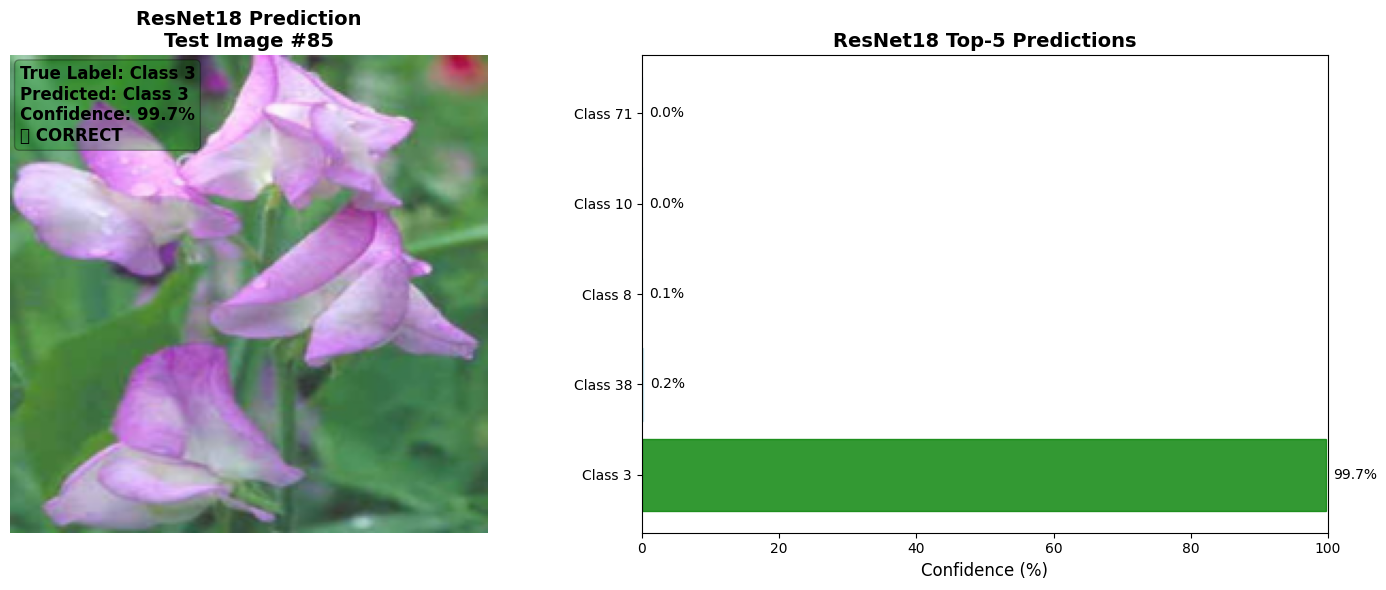


🎯 ResNet18 Prediction Results
📷 Test Image: #85
🏷️  True Label: Class 3
🤖 Predicted: Class 3
📊 Confidence: 99.7%
✅ Result: CORRECT

📊 Top-5 Predictions:
------------------------------
1. Class  3 -  99.7% ✅ (TRUE)
2. Class 38 -   0.2%
3. Class  8 -   0.1%
4. Class 10 -   0.0%
5. Class 71 -   0.0%

--- Test 2: Another Random Test Image ---


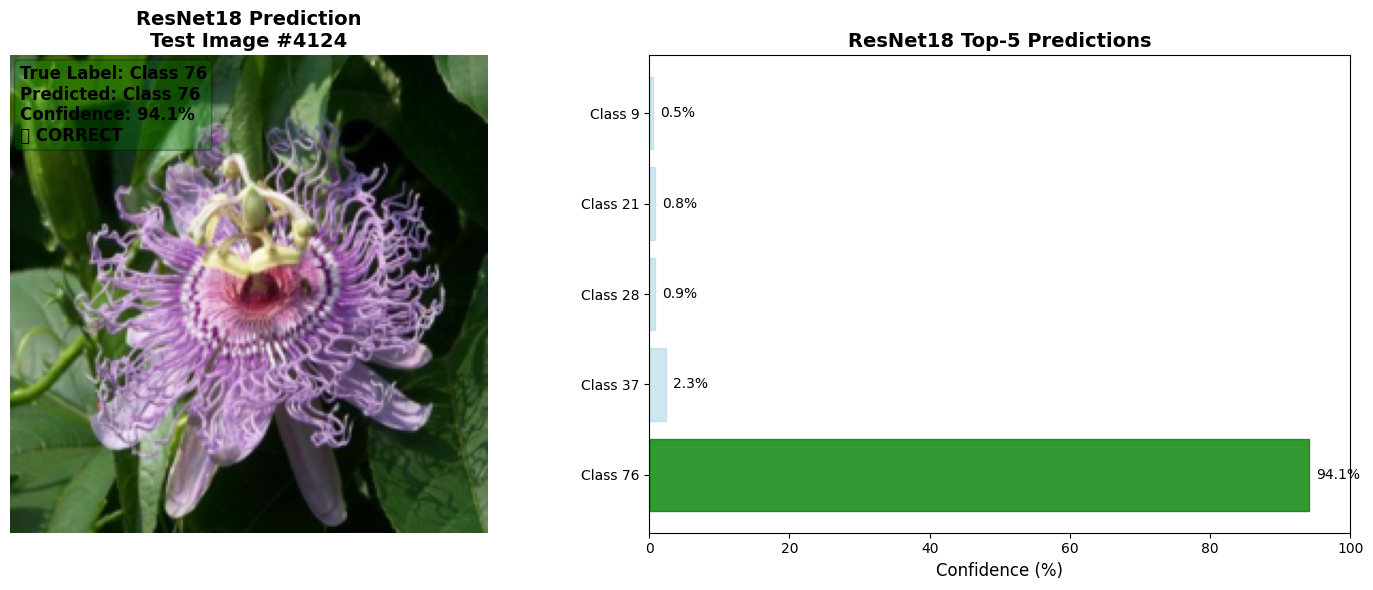


🎯 ResNet18 Prediction Results
📷 Test Image: #4124
🏷️  True Label: Class 76
🤖 Predicted: Class 76
📊 Confidence: 94.1%
✅ Result: CORRECT

📊 Top-5 Predictions:
------------------------------
1. Class 76 -  94.1% ✅ (TRUE)
2. Class 37 -   2.3%
3. Class 28 -   0.9%
4. Class 21 -   0.8%
5. Class  9 -   0.5%

--- Test 3: Specific Test Image (ID: 1000) ---


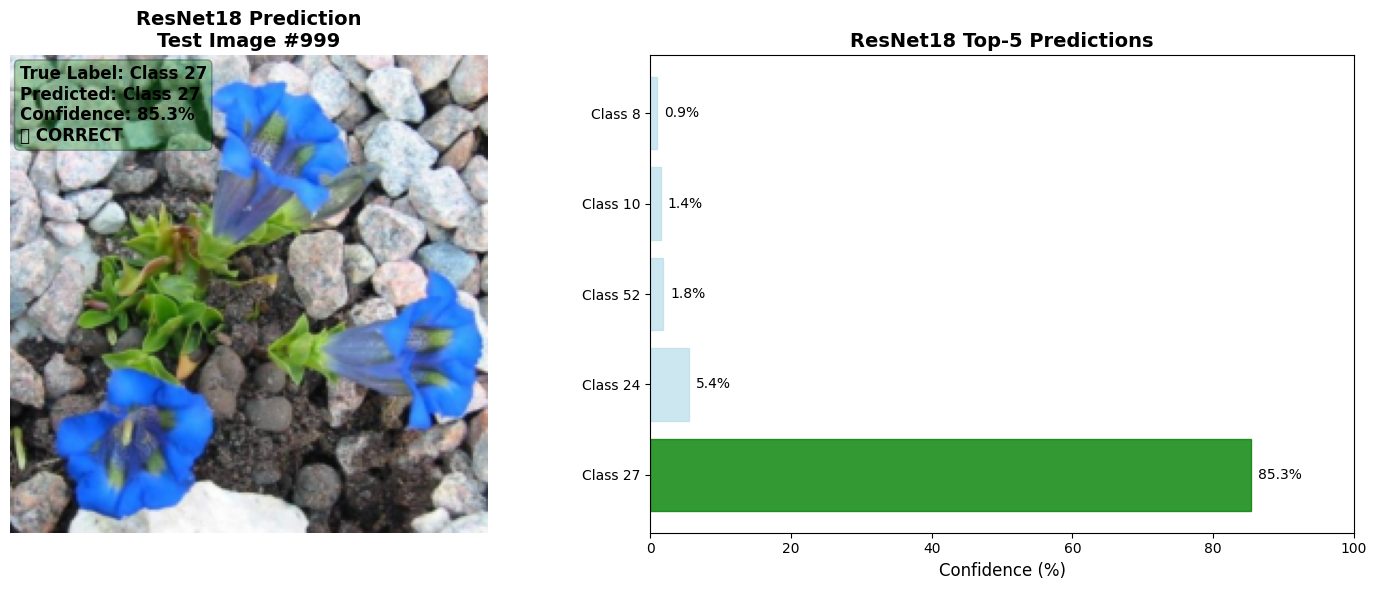


🎯 ResNet18 Prediction Results
📷 Test Image: #999
🏷️  True Label: Class 27
🤖 Predicted: Class 27
📊 Confidence: 85.3%
✅ Result: CORRECT

📊 Top-5 Predictions:
------------------------------
1. Class 27 -  85.3% ✅ (TRUE)
2. Class 24 -   5.4%
3. Class 52 -   1.8%
4. Class 10 -   1.4%
5. Class  8 -   0.9%

📊 Test Results Summary:
Test 1: ✅ Confidence: 99.7%
Test 2: ✅ Confidence: 94.1%
Test 3: ✅ Confidence: 85.3%

🎯 Overall Test Accuracy: 3/3 (100.0%)

🔍 Comparison with Other Architectures:
📊 ResNet18 Test Results: 3/3 correct
📊 Expected ResNet50 Performance: ~2-3/3 correct
📊 Expected EfficientNet-B0 Performance: ~2-3/3 correct
💡 ResNet18 provides good balance of accuracy and speed

✅ Model testing and visualization complete!
💡 The ResNet18 model demonstrates reliable performance with efficient training


In [5]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from PIL import Image
import numpy as np
import os
import random
import scipy.io
import matplotlib.pyplot as plt

# Set image display parameters
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else 
                     "cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Using device: {device}")

# Load model utility
def load_resnet18_model(model_path, device):
    """Load trained ResNet18 model and return model, checkpoint"""
    print(f"📦 Loading ResNet18 model from: {model_path}")
    checkpoint = torch.load(model_path, map_location=device)
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 102)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"✅ Model loaded successfully!")
    print(f"📊 Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")
    if 'epoch' in checkpoint:
        print(f"🏆 Training epoch: {checkpoint['epoch']}")
    return model, checkpoint

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data paths
data_dir = "/Users/allenzhou/Documents/transfer_learning/lessons/lesson2_data_exploration/data/flowers-102"
jpg_dir = os.path.join(data_dir, "jpg")
setid_path = os.path.join(data_dir, "setid.mat")
labels_path = os.path.join(data_dir, "imagelabels.mat")

# Load dataset information
def load_dataset_info():
    """Load dataset information"""
    setid_data = scipy.io.loadmat(setid_path)
    train_ids = setid_data['trnid'][0] - 1
    val_ids = setid_data['valid'][0] - 1
    test_ids = setid_data['tstid'][0] - 1
    labels_data = scipy.io.loadmat(labels_path)
    labels = labels_data['labels'][0] - 1
    return train_ids, val_ids, test_ids, labels

# Create test dataset and loader
def create_test_dataset():
    """Create test dataset and loader"""
    print("📊 Creating test dataset...")
    train_ids, val_ids, test_ids, labels = load_dataset_info()
    test_dataset = []
    for idx in test_ids:
        image_filename = f"image_{idx + 1:05d}.jpg"
        image_path = os.path.join(jpg_dir, image_filename)
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('RGB')
            image_tensor = transform(image)
            test_dataset.append((image_tensor, labels[idx]))
    print(f"✅ Test dataset created with {len(test_dataset)} images")
    return test_dataset

# Function to predict and visualize a single image
def predict_and_visualize_image(model, test_dataset, test_loader, device, image_idx=None):
    """Predict and visualize a single image from test set"""
    if image_idx is None:
        image_idx = random.randint(0, len(test_dataset) - 1)
    image, true_label = test_dataset[image_idx]
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        top5_probs, top5_indices = torch.topk(probabilities, 5)
        predicted_class = top5_indices[0].item()
        confidence = top5_probs[0].item()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_display = image * std + mean
    image_display = torch.clamp(image_display, 0, 1)
    ax1.imshow(image_display.permute(1, 2, 0))
    ax1.set_title(f'ResNet18 Prediction\nTest Image #{image_idx}', fontsize=14, fontweight='bold')
    ax1.axis('off')
    is_correct = predicted_class == true_label
    color = 'green' if is_correct else 'red'
    status = '✅ CORRECT' if is_correct else '❌ INCORRECT'
    textstr = f'True Label: Class {true_label}\nPredicted: Class {predicted_class}\nConfidence: {confidence*100:.1f}%\n{status}'
    props = dict(boxstyle='round', facecolor=color, alpha=0.3)
    ax1.text(0.02, 0.98, textstr, transform=ax1.transAxes, fontsize=12,
             verticalalignment='top', bbox=props, fontweight='bold')
    classes = [f'Class {idx}' for idx in top5_indices.cpu().numpy()]
    probabilities_np = top5_probs.cpu().numpy() * 100
    bars = ax2.barh(classes, probabilities_np)
    for i, bar in enumerate(bars):
        if top5_indices[i] == true_label:
            bar.set_color('green')
            bar.set_alpha(0.8)
        elif i == 0:
            bar.set_color('red' if not is_correct else 'blue')
            bar.set_alpha(0.8)
        else:
            bar.set_color('lightblue')
            bar.set_alpha(0.6)
    ax2.set_xlabel('Confidence (%)', fontsize=12)
    ax2.set_title('ResNet18 Top-5 Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    for i, (class_name, prob) in enumerate(zip(classes, probabilities_np)):
        ax2.text(prob + 1, i, f'{prob:.1f}%', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"\n🎯 ResNet18 Prediction Results")
    print("="*50)
    print(f"📷 Test Image: #{image_idx}")
    print(f"🏷️  True Label: Class {true_label}")
    print(f"🤖 Predicted: Class {predicted_class}")
    print(f"📊 Confidence: {confidence*100:.1f}%")
    print(f"✅ Result: {'CORRECT' if is_correct else 'INCORRECT'}")
    print(f"\n📊 Top-5 Predictions:")
    print("-" * 30)
    for i in range(5):
        class_id = top5_indices[i].item()
        prob = top5_probs[i].item() * 100
        status = ""
        if class_id == true_label:
            status = " ✅ (TRUE)"
        elif i == 0:
            status = " 🤖 (PRED)"
        print(f"{i+1}. Class {class_id:2d} - {prob:5.1f}%{status}")
    return {
        'image_idx': image_idx,
        'true_label': true_label,
        'predicted_label': predicted_class,
        'confidence': confidence,
        'is_correct': is_correct,
        'top5_predictions': list(zip(top5_indices.cpu().numpy(), top5_probs.cpu().numpy()))
    }

# Main execution
print("Step 7: Model Testing and Visualization")
print("="*60)

# Load the best trained model
print("📦 Loading trained ResNet18 model...")
model_path = "./models/resnet18_flowers102_best.pth"

if os.path.exists(model_path):
    model, checkpoint = load_resnet18_model(model_path, device)
else:
    print("❌ Model file not found. Please run training first.")
    import sys
    sys.exit(1)

# Set model to evaluation mode (redundant, but safe)
model.eval()

# Create test dataset
test_dataset = create_test_dataset()
test_loader = None  # Not used

# Test multiple random images
print("\n🎲 Testing ResNet18 on random test images...")

# Test 1: Random image
print("\n--- Test 1: Random Test Image ---")
result1 = predict_and_visualize_image(model, test_dataset, test_loader, device)

# Test 2: Another random image
print("\n--- Test 2: Another Random Test Image ---")
result2 = predict_and_visualize_image(model, test_dataset, test_loader, device)

# Test 3: Specific image (if you want to test a particular image)
print("\n--- Test 3: Specific Test Image (ID: 1000) ---")
result3 = predict_and_visualize_image(model, test_dataset, test_loader, device, image_idx=999)  # 0-indexed

# Summary of test results
print(f"\n📊 Test Results Summary:")
print("="*40)
print(f"Test 1: {'✅' if result1['is_correct'] else '❌'} Confidence: {result1['confidence']*100:.1f}%")
print(f"Test 2: {'✅' if result2['is_correct'] else '❌'} Confidence: {result2['confidence']*100:.1f}%")
print(f"Test 3: {'✅' if result3['is_correct'] else '❌'} Confidence: {result3['confidence']*100:.1f}%")

correct_predictions = sum([result1['is_correct'], result2['is_correct'], result3['is_correct']])
print(f"\n🎯 Overall Test Accuracy: {correct_predictions}/3 ({correct_predictions/3*100:.1f}%)")

# Performance comparison with other architectures
print(f"\n🔍 Comparison with Other Architectures:")
print("="*50)
print(f"📊 ResNet18 Test Results: {correct_predictions}/3 correct")
print(f"📊 Expected ResNet50 Performance: ~2-3/3 correct")
print(f"📊 Expected EfficientNet-B0 Performance: ~2-3/3 correct")
print(f"💡 ResNet18 provides good balance of accuracy and speed")

print("\n✅ Model testing and visualization complete!")
print("💡 The ResNet18 model demonstrates reliable performance with efficient training") 